# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

### А ещё есть консультация 2023 года :)

https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

Отдельная благодарность А. Абрамову за написание assert для проверки функций и В. Гилязову за поясняющую картинку.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip





--2024-11-25 19:42:17--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2024-11-25 19:42:17--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.1s    

2024-11-25 19:42:17 (153 MB/s) - ‘data.zip’ saved [17592727/17592727]



In [ ]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 18.8 MB/s eta 0:00:00


In [ ]:
!rm -rf */
import py7zr
import zipfile

with zipfile.ZipFile("data.zip",'r') as zip_ref:
  zip_ref.extractall()

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        # то есть res выглядит как [xmin, ymin, xmax, ymax, class]
        # всё в int!
        # Для корректной работы клеточек ниже требуется конкретная последовательность координат
        # См. доку https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # Нас интересует pascal_voc формат, далее применяется он.
        res =  [0,0,0,0,0]
        res[0] = int(member.find("bndbox/xmin").text)
        res[1] = int(member.find("bndbox/ymin").text)
        res[2] = int(member.find("bndbox/xmax").text)
        res[3] = int(member.find("bndbox/ymax").text)
        name = str(member.find("name").text)
        res[4] = class_dict[name]
        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="data", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Нужно обладая файлнеймом подгрузить картинку и бибоксы, функцию для подгрузки бибоксов вы дописали выше :)
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname,self.root,self.class_dict)

        # transform будут объявлены ниже за вас
        # Но библиотека привередлива к формату данных на входе, внимательно прочтите прошлую клеточку
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
from torchvision import transforms
import matplotlib.patches as patches
def visualize(images, bboxes):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    to_PIL = transforms.ToPILImage
    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break


        image = images[i] * std + mean
        image = image.permute(1, 2, 0).clamp(0, 1)


        image = (image.numpy() * 255).astype(np.uint8)

        ax.imshow(image)


        for bbox in bboxes[i]:
            rect = Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                edgecolor="pink",
                linewidth=2,
                fill=False
            )
            ax.add_patch(rect)
            ax.text(bbox[0], bbox[1], train_ds.class_dict_inv[bbox[4]], color='pink', fontsize=10, verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

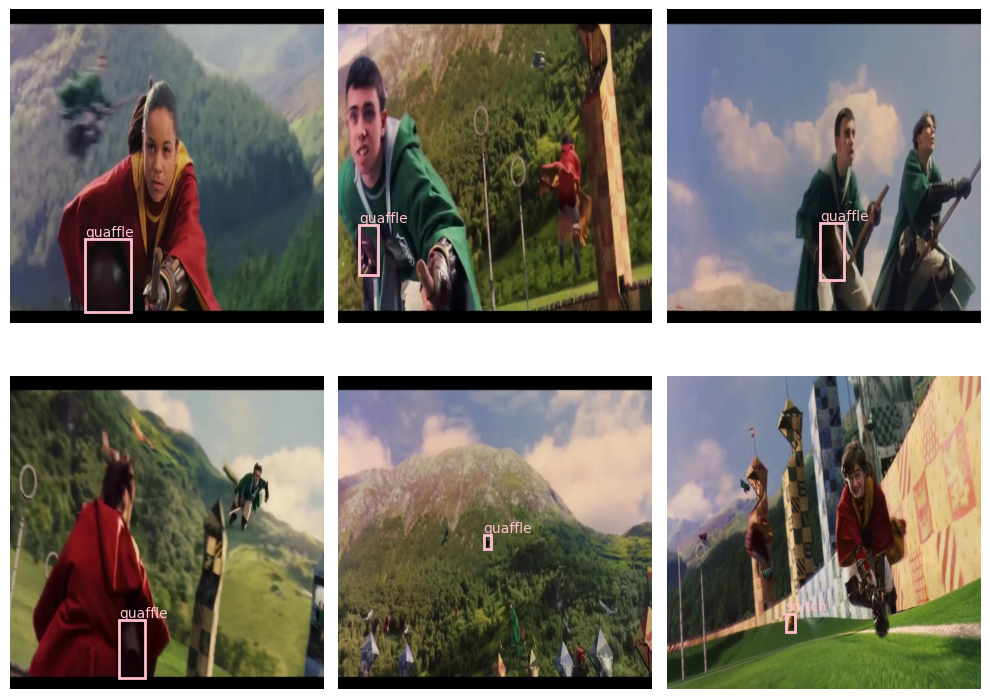

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код.

В шести "каналах" у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.

Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)

![image](https://i.imgur.com/13YVxAd.jpeg)

In [ ]:
def tensor_g(tensor,ind):
  if tensor.dim() == 0:
    return tensor
  else:
    return tensor[ind]
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)
    last_image = None
    # Add sample index to target

    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        for j in range(len(boxes)):


        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        #x_cell =  # TODO размер клетки по X в пикс
        #y_cell =  # TODO размер клетки по Y в пикс

        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
          w_box =  abs(tensor_g(xmin, j) - tensor_g(xmax, j))/512 # TODO ширина бокса отнормированная на размер изначальной картинки
          h_box =  abs(tensor_g(ymin, j) - tensor_g(ymax, j))/512 # TODO высота бокса отнормированная на размер изначальной картинки

        # Посчитайте координаты центра и сдвиги
          cx =  (tensor_g(xmin, j)+tensor_g(xmax, j))/2# TODO (координаты центра в исходных координатах)
          cy =  (tensor_g(ymin,j)+tensor_g(ymax,j))/2# TODO

          cx_idx = int(cx // downsample)# TODO (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
          cy_idx = int(cy // downsample)# TODO


          cx_box =  abs(cx_idx*downsample - cx)/downsample
          cy_box =  abs(cy_idx*downsample - cy)/downsample

        # cy_idx, потом cx_idx
          target[i, :, cy_idx, cx_idx] = torch.stack(
              [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), tensor_g(classes,j)]
        )

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [ ]:
def test_collate_fn() -> None:
    target1 = [ 100, 200, 200, 300, 2 ] # xmin, ymin, xmax, ymax, class
    target2_1 = [ 0, 250, 200, 300, 0 ] # xmin, ymin, xmax, ymax, class
    target2_2 = [ 0, 100, 100, 300, 1 ] # xmin, ymin, xmax, ymax, class

    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target1 ] },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': [ target2_1, target2_2 ] }
    ])

    # Проверяем размерности
    assert result['image'].shape == (2, 3, 512, 512)
    assert result['target'].shape == (2, 6, 16, 16)

    # Проверяем значения клеточек, в которые попали ббоксы
    assert np.allclose(result['target'][0, :, 7, 4], torch.tensor([ 22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2 ]))
    #print(result['target'][1, :, 8, 3],torch.tensor([ 4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0 ]))
    assert np.allclose(result['target'][1, :, 8, 3], torch.tensor([ 4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0 ]))

    assert np.allclose(result['target'][1, :, 6, 1], torch.tensor([ 18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1 ]))

    # Проверяем, что все остальные клеточки содержат нули
    result['target'][0, :, 7, 4] = result['target'][1, :, 8, 3] = result['target'][1, :, 6, 1] = torch.zeros(6)
    assert np.allclose(result['target'], 0)

test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

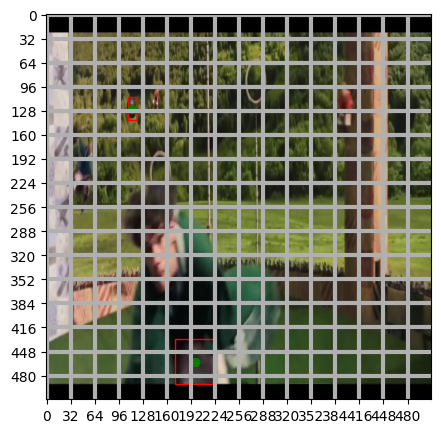

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###
    result = []
    obj_on_pict = []
    for img in range (b):
      prom = []
      for y_idx in range (h):
        for x_idx in range (w):
          if pred[img,:,y_idx,x_idx].sum() != 0:

            obj = pred[img,:,y_idx,x_idx]
            w_box = obj[2]
            h_box = obj[3]

            x_min = round((x_idx*upsample +obj[0]*upsample - w_box*img_w/2).item())
            x_max = round((x_idx*upsample +obj[0]*upsample + w_box*img_w/2).item())
            y_min = round((y_idx*upsample +obj[1]*upsample - h_box*img_h/2).item())
            y_max = round((y_idx*upsample +obj[1]*upsample + h_box*img_h/2).item())

            obj_on_pict.append(x_min)
            obj_on_pict.append(y_min)
            obj_on_pict.append(x_max)
            obj_on_pict.append(y_max)


            if pred[img,:,y_idx,x_idx].dim() == 6:
              obj_on_pict.append(pred[img,:,y_idx,x_idx][5].item())
              prom.append(obj_on_pict)
            elif(pred[img,4,y_idx,x_idx]>threshold):
              obj_on_pict.append(torch.argmax(pred[img,5:,y_idx,x_idx]).item())
              prom.append(obj_on_pict)
            obj_on_pict = []
      result.append(prom)
    return result

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [ ]:
def test_decode_predictions() -> None:
    # Применяем collate_fn к некоторым данным
    target1 = [ [ 100, 200, 200, 300, 2 ] ]
    target2 = [ [ 0, 250, 200, 300, 0 ], [ 0, 100, 100, 300, 1 ] ]
    result = collate_fn([
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target1 },
        { 'image': torch.rand((3, 512, 512)), 'bboxes': target2 }
    ])

    target = result['target']
    assert target.shape == (2, 6, 16, 16)
    # В таком виде target соответствует поиску одного класса - 6-ой канал.
    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов
    target = torch.cat([ target, torch.zeros(2, 2, 16, 16) ], dim = 1) # Добавляем два канала
    assert target.shape == (2, 8, 16, 16) # Теперь их стало 8

    target[0, 5:, 7, 4] = torch.tensor([ 0.5, 0.6, 0.9 ]) # Это должен быть класс 2
    target[1, 5:, 8, 3] = torch.tensor([ 0.9, 0.6, 0.5 ]) # Это должен быть класс 0
    target[1, 5:, 6, 1] = torch.tensor([ 0.6, 0.9, 0.5 ]) # Это должен быть класс 1


    # Считаем результат
    actual = decode_prediction(target)
    print('Actual:  ', actual)

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.
    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.
    expected = [ target1, [ target2[1], target2[0] ] ]
    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.
    print('Expected:', expected)

    # Сравниваем
    assert actual == expected

test_decode_predictions()

Actual:   [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [ ]:
C =  len(train_ds.class_dict_inv)



class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        ### YOUR CODE HERE ###

        self.resn = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )

        self.conv_layers = nn.Sequential(
            nn.Conv2d(2048,512,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,5+C,kernel_size=3,padding=1),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = self.resn(img)
        res = self.conv_layers(x)

        return res
#Оказывается если не вернуть результат то модель не будет работать

In [ ]:
list(torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT).children())

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.4MB/s]


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
def special_loss(pred, target, C=C, ignore_threshold = 0.1):
    ### YOUR CODE HERE ###
    target_2nd = target[1]
    where_obj = target_2nd[4]
    obj_mask = (where_obj > 0)
    no_obj_mask = ~obj_mask


    pred_boxes = pred[:, :4, :, :]
    pred_confidence = pred[:, 4, :, :]
    pred_classes = pred[:, 5:, :, :]

    target_boxes = target[:, :4, :, :]
    target_classes = target[:, 4, :, :]

    first_two = torch.masked_select(pred_boxes[:, 0:2, :, :], obj_mask  )



    localization_loss = nn.MSELoss(reduction='sum')(torch.masked_select(pred_boxes[:, 0:2, :, :],
                        obj_mask  ),torch.masked_select(target_boxes[:, 0:2, :, :],
                        obj_mask))


    box_loss = nn.MSELoss(reduction='sum')(
        torch.masked_select(pred_boxes[:, 2:, :, :], obj_mask).sqrt(),
        torch.masked_select(target_boxes[:, 2:, :, :], obj_mask).sqrt()
    )

    mask_0 = (target[:, 4, :, :] == 0).float()
    mask_1 = (target[:, 4, :, :] == 1).float()
    mask_2 = (target[:, 4, :, :] == 2).float()

    obj_mask = (target[:,4,:,:]>0)
    no_obj_mask = ~obj_mask

    target_class =  torch.masked_select(target[:,5,:,:], obj_mask)
    pred_part_gg = []
    classes = []
    for class_pot in range(C):
        classes.append(torch.masked_select(pred[:, 5 + class_pot, :, :], obj_mask).unsqueeze(1))

    class_sh = torch.cat(classes, dim=1)

    target_nw = torch.masked_select(target[:, 5, :, :], obj_mask).long()

    classification_loss = nn.CrossEntropyLoss(reduction='sum')(class_sh, target_nw)




    obj_mask = (target[:,4,:,:]>0)
    no_obj_mask = ~obj_mask

    confidence_loss_detected = nn.BCELoss(reduction='sum')(torch.masked_select(pred_confidence,obj_mask),torch.masked_select(target[:,4,:,:], obj_mask))

    confidence_loss_not_detected = nn.BCELoss(reduction='sum')(torch.masked_select(pred_confidence, no_obj_mask),torch.masked_select(target[:,4,:,:], no_obj_mask))



    confidence_loss = confidence_loss_detected + (ignore_threshold * confidence_loss_not_detected)
    print(localization_loss, box_loss, classification_loss, confidence_loss)
    return localization_loss + box_loss + classification_loss + confidence_loss

In [ ]:
print()

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
print(loader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  20
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        pic, targets = batch["image"], batch["target"]
        pic = pic.to(device)
        targets = targets.to(device)

        opt.zero_grad()
        pred = model(pic)

        loss = special_loss(pred,targets)
        loss.backward()
        opt.step()



    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(8.4452, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(16.8274, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(14.6257, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(208.0724, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3345, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(15.7087, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(11.5879, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(178.3185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.0017, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.2240, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(11.5076, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(157.7403, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1996, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.6984, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(11.1107, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(141.2168, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9811, device='cuda:0', grad_fn=<M

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/26 [00:00<?, ?it/s]

tensor(1.6509, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(3.0960, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(13.0952, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(31.7286, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8512, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(2.6811, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(11.2755, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(29.0280, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2908, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.2332, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(10.3613, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(29.5289, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5668, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.0950, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(9.9666, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(25.4805, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0601, device='cuda:0', grad_fn=<MseLossB

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(1.2349, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.6362, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(12.2005, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(13.1425, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9005, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.8125, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(8.4938, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(14.4111, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6772, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.2677, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(8.6161, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(10.4621, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3025, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.5359, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(8.3619, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(9.8687, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6561, device='cuda:0', grad_fn=<MseLossBack

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.7321, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.3678, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(10.5938, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(7.3430, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3953, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.7479, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(8.3270, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(11.1397, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4104, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.2117, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.6846, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(6.3954, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1385, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1670, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.9734, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(6.8345, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3222, device='cuda:0', grad_fn=<MseLossBackwa

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.4139, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.3306, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(10.3802, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(4.8158, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2860, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.3655, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.8337, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(5.4199, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2082, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.2181, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.8184, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(3.4928, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0764, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1443, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.8795, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(6.6532, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2977, device='cuda:0', grad_fn=<MseLossBackwar

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.6704, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.2377, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(8.5621, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.1531, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1605, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.3477, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.5174, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(3.9344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1200, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1119, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.3316, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.9997, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0991, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0867, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.8008, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.0855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1879, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.2212, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1600, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(9.6771, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.8210, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1634, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1683, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.8017, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.1896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0630, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0585, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.7383, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.6280, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1734, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0751, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.1215, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.2294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3050, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.2699, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1545, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(8.7597, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(7.8337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1731, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1222, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.2500, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(4.2555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6448, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1095, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.6947, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(16.7965, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2957, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0791, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.3277, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(3.0377, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2063, device='cuda:0', grad_fn=<MseLossBackwar

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.4972, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1512, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(9.5794, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(7.4549, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1930, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1830, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.9651, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(6.6699, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3580, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1709, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.6173, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(3.6933, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1779, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0620, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.2889, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.9536, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5499, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.3229, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1496, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(8.1743, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(4.1051, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1562, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.2994, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.8913, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(4.8852, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2076, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0729, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.4363, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(6.2602, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1505, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0888, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.1771, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.8346, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2528, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.3233, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1743, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(8.5686, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(5.1261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2227, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1310, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.3037, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(4.8455, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1205, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0391, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.5523, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.3069, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1011, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0667, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.4105, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(3.3095, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1896, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.2468, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0777, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.7532, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(6.3532, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0814, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.1049, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.3471, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.4419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1629, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.4459, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.5976, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0598, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0292, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.2658, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.0177, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2220, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.4252, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0576, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.2342, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.2179, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0869, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0771, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.6558, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.5558, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1906, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0377, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.3785, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.7106, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0977, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.8365, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(4.3371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1965, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.1876, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0592, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.4226, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(4.9422, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1404, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0739, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.1930, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(4.2698, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0817, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.6911, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.8807, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0775, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0469, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.1604, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.3914, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1099, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.1957, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0843, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.1884, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.7413, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1440, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0790, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0933, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.1601, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1360, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0762, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.9647, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0762, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0819, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.8246, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0800, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.2013, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0392, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.1901, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5254, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1783, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0585, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0851, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0883, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0719, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.3653, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0865, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0445, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0827, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.4483, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1203, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.1469, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0335, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.1841, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.3549, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0449, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0772, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.3370, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1857, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0738, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.3252, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0769, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.3027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0941, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.0565, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.1824, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2811, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0557, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0754, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2579, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2015, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0717, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2379, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0736, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2459, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1042, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.0545, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.1849, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2449, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0772, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0638, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0760, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0763, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2122, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0644, device='cuda:0', grad_fn=<MseLossBackward

  0%|          | 0/26 [00:00<?, ?it/s]

tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(7.1818, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2165, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0632, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0725, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0505, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0696, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.1968, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(6.0710, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0535, device='cuda:0', grad_fn=<MseLossBackward

Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

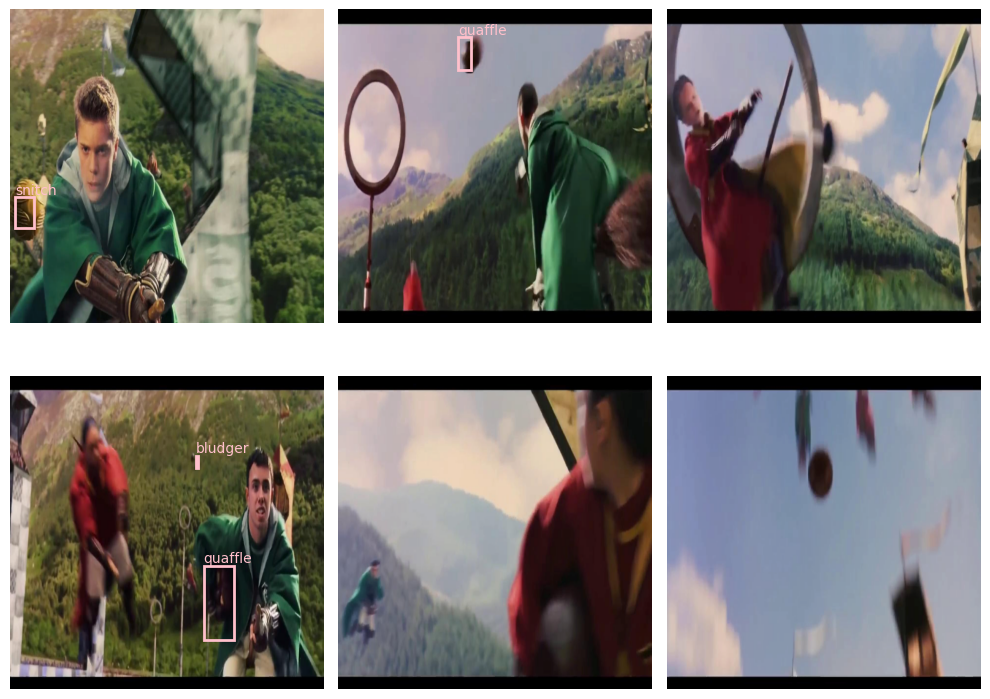

In [ ]:
model.eval()
img = batch["image"]
img = img.to(device)

with torch.no_grad():
  pred = model(img)

bboxes = decode_prediction(pred)
img = img.to("cpu")
visualize(img,bboxes)

In [ ]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

### YOUR CODE HERE ###

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO 11 от ultralytics.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 21.1 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:

!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        # то есть res выглядит как [xmin, ymin, xmax, ymax, class]
        # всё в int!
        # Для корректной работы клеточек ниже требуется конкретная последовательность координат
        # См. доку https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # Нас интересует pascal_voc формат, далее применяется он.
        res =  [0,0,0,0,0]
        res[0] = int(member.find("bndbox/xmin").text)
        res[1] = int(member.find("bndbox/ymin").text)
        res[2] = int(member.find("bndbox/xmax").text)
        res[3] = int(member.find("bndbox/ymax").text)
        name = str(member.find("name").text)
        res[4] = class_dict[name]
        bboxes.append(res)

    return bboxes

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    strings =[]
    for i in range(len(bboxes)):
        xmin, ymin, xmax, ymax, class_pict = bboxes[i]

        w_box =  abs(xmin - xmax)/w_im # TODO ширина бокса отнормированная на размер изначальной картинки
        h_box =  abs(ymin - ymax)/h_im # TODO высота бокса отнормированная на размер изначальной картинки

        # Посчитайте координаты центра и сдвиги
        cx =  (xmin + xmax)/2# TODO (координаты центра в исходных координатах)
        cy =  (ymin + ymax)/2# TODO

        cx_norm =  cx/w_im
        cy_norm =  cy/h_im

        strings.append(str(class_pict)+" "+str(cx_norm)+" " + str(cy_norm)+" " +str(w_box)+ " " + str(h_box))

    return strings

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  3 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
dict_of_names = test_ds.class_dict
names =  list(dict_of_names.keys())# Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.

Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)

Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):

https://github.com/ultralytics/ultralytics/issues/1149

https://github.com/ultralytics/yolov5/issues/6907

https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [ ]:
import ultralytics

model = ultralytics.YOLO("yolo11n.pt")

results = model.train(data = "data.yaml", epochs = 50)
#видимо есть
results = model.val()
results

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 59.4MB/s]


Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

100%|██████████| 755k/755k [00:00<00:00, 18.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/train/labels... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 1964.01it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 985.82it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.46G       1.28      4.519      1.128         27        640: 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         29         32    0.00132      0.401    0.00274    0.00158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.36G      1.331      3.604      1.086         33        640: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         29         32    0.00139      0.363    0.00896    0.00417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.35G      1.401      3.071      1.116         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         29         32    0.00148      0.432    0.00651    0.00423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.36G      1.333      2.661      1.085         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         29         32    0.00149      0.464     0.0556      0.042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.36G      1.333      2.591      1.079         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         29         32      0.466     0.0787      0.129     0.0885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.35G      1.289      2.291      1.071         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         29         32      0.615     0.0995      0.167      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.36G      1.281      2.264      1.058         38        640: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         29         32      0.503      0.251      0.344        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.36G      1.287      2.157       1.06         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         29         32       0.68      0.558      0.549      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.36G      1.244      1.968      1.043         33        640: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         29         32      0.619      0.249      0.393      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.36G      1.212      1.873      1.018         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         29         32      0.536      0.578       0.61      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.36G       1.22      1.773      1.029         37        640: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         29         32      0.729      0.426      0.555      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.37G      1.164      1.628     0.9975         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         29         32      0.682        0.6      0.709      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.37G      1.188      1.672          1         28        640: 100%|██████████| 16/16 [00:03<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29         32      0.718      0.654      0.647      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.37G      1.108      1.441     0.9836         35        640: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         29         32      0.591      0.696      0.673      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.37G      1.134       1.44     0.9994         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         29         32      0.809      0.695      0.777      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.36G      1.092      1.383     0.9832         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         32      0.899      0.486      0.668      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.36G      1.119      1.348      1.003         34        640: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         29         32      0.715      0.532      0.655      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.36G      1.078      1.307     0.9896         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         29         32      0.799      0.627      0.749      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.37G      1.057      1.217     0.9763         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         29         32      0.832      0.743      0.815      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.36G      1.033      1.149     0.9615         30        640: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         29         32      0.826      0.709      0.742      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.37G      1.027      1.175     0.9683         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         29         32      0.761      0.774      0.791      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.37G      1.036      1.098     0.9719         24        640: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         29         32      0.781      0.725      0.801      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.36G       0.97      1.069      0.944         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         29         32      0.723      0.727      0.792      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.36G      1.026      1.059     0.9432         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         32      0.823      0.568      0.714      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.36G     0.9609      1.048      0.941         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         29         32       0.85      0.633      0.791      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.36G     0.8895     0.9235     0.9124         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         29         32      0.881      0.646       0.79      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.36G     0.9474     0.9634     0.9181         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         29         32      0.834      0.561      0.734      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.36G      0.929     0.9724     0.9093         21        640: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         29         32      0.754      0.707      0.793      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.36G     0.9503     0.9398     0.9249         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         29         32      0.741      0.679      0.788       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.36G     0.9115     0.8974     0.9201         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         29         32       0.83      0.576      0.764      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.36G     0.9066     0.8308     0.9035         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         29         32      0.839      0.775       0.83      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.36G     0.9017     0.8636     0.9306         37        640: 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         29         32      0.884      0.756      0.848      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.36G     0.9211     0.8849     0.9298         34        640: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         29         32      0.897      0.804      0.886      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.36G     0.8827     0.8132     0.9112         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         32      0.947      0.802      0.877       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.36G     0.8727     0.7886     0.9207         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         29         32      0.886      0.795      0.895      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.36G     0.8299      0.795     0.8727         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         29         32      0.831      0.784      0.863       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.36G      0.865     0.7833      0.882         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         29         32      0.839      0.772      0.838      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.37G     0.8051     0.7209     0.8784         30        640: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         29         32      0.874      0.786      0.865       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.36G     0.8299     0.7334     0.8986         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         29         32      0.867      0.816      0.866       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.36G     0.8191      0.725     0.9059         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         29         32       0.78      0.851      0.899      0.574


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.44G     0.8387      0.857     0.8784         15        640: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         29         32      0.787      0.874      0.863      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.37G     0.7993     0.8562     0.8646         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         29         32      0.767      0.869       0.86      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.37G     0.7968     0.8178     0.8796         15        640: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         29         32      0.819      0.861      0.883      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.37G     0.7859     0.7641     0.8719         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         29         32      0.794      0.901      0.891       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.37G     0.7483     0.7624      0.856         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         29         32       0.83      0.873      0.882      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.37G     0.7777     0.7583     0.8648         14        640: 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         29         32      0.836      0.874       0.88      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.37G     0.7694     0.7386     0.8582         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         29         32       0.83      0.817      0.884      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.36G     0.7463      0.741     0.8449         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         29         32      0.839      0.812       0.89      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.37G     0.6983     0.7143     0.8372         15        640: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         29         32      0.841      0.812      0.889      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.37G     0.7446     0.7204     0.8652         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         29         32       0.89      0.805      0.895      0.599



50 epochs completed in 0.095 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


                   all         29         32      0.829      0.817      0.885      0.603
                snitch          7          7      0.875      0.857      0.904      0.654
               quaffle         16         16      0.728       0.75      0.813      0.554
               bludger          9          9      0.883      0.845      0.938      0.602
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.37 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/valid/labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


                   all         29         32      0.823      0.832      0.886      0.591
                snitch          7          7      0.879      0.857      0.909      0.657
               quaffle         16         16      0.737       0.75      0.821      0.534
               bludger          9          9      0.853      0.889      0.926      0.583
Speed: 0.1ms preprocess, 24.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d500c035cf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
predictions = model.predict(source='data/images/val', save=True)


In [ ]:
import locale
import sys

try:
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
except locale.Error:
    print("Failed to set locale to UTF-8.")
    sys.exit(1)

In [ ]:
!mkdir -p output

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

predictions = model.predict(source='valid/images', save=True)


output_dir = 'output'

saved_images = os.listdir(output_dir)

sample_images = saved_images[:10]


plt.figure(figsize=(15, 10))

for i, img_file in enumerate(sample_images):

    img_path = os.path.join(output_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predictions {i+1}')

plt.tight_layout()
plt.show()
